### CONFIGURACAO AMBIENTE

In [41]:
# Importar as bibliotecas necessárias
import pandas as pd
import os
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sqlalchemy import create_engine
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Configurações do banco de dados
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = int(os.getenv("DB_PORT", 5432))



# Criar o engine de conexão usando SQLAlchemy
connection_string = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(connection_string)

# Criar uma conexão a partir do engine
connection = engine.raw_connection()


### DATA LOAD

In [42]:
# Carregar os dados da tabela de exportação
query = "SELECT * FROM exportacao;"
df_exportacao = pd.read_sql(query, con=connection)

# Fechar a conexão
connection.close()

# Visualizar os primeiros registros dos dados carregados
df_exportacao.head()


/tmp/ipykernel_152055/2683005586.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_exportacao = pd.read_sql(query, con=connection)


,id,ano,pais,quantidade_litros,valor_usd,data_insercao
0,1,2023,Afeganistão,NaN,NaN,2025-03-30 18:27:41.917881
1,139,2022,Afeganistão,NaN,NaN,2025-03-30 18:28:15.759746
2,140,2022,África do Sul,NaN,NaN,2025-03-30 18:28:15.759746
3,141,2022,"Alemanha, República Democrática",7630.0,45367.0,2025-03-30 18:28:15.759746
4,142,2022,Angola,4068.0,4761.0,2025-03-30 18:28:15.759746


### DATA PREPARATION

#### CLEANING

In [43]:
# Substituir "-" por NaN nas colunas 'quantidade_litros' e 'valor_usd'
df_exportacao['quantidade_litros'] = pd.to_numeric(df_exportacao['quantidade_litros'], errors='coerce')
df_exportacao['valor_usd'] = pd.to_numeric(df_exportacao['valor_usd'], errors='coerce')

# Remover linhas com valores ausentes (NaN) em 'quantidade_litros' ou 'valor_usd'
df_clean = df_exportacao.dropna(subset=['quantidade_litros', 'valor_usd'])
# Dropar a coluna 'data_insercao'
df_clean = df_clean.drop(columns=['data_insercao'])
# # Excluir a coluna 'id'
df_clean = df_clean.drop(columns=['id'])

# Verificar se há mais dados ausentes após limpeza
df_clean.isnull().sum()

ano                  0
pais                 0
quantidade_litros    0
valor_usd            0
dtype: int64

#### FEATURE ENGINEERING

In [44]:
# Salvar o DataFrame em um arquivo CSV
df_clean.to_csv('dados_para_treinamento.csv', index=False, encoding='utf-8')

print("Dados salvos com sucesso no arquivo 'dados_para_treinamento.csv'")

Dados salvos com sucesso no arquivo 'dados_para_treinamento.csv'


### ANALISE EXPLORATORIA

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 3 to 1379
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ano                565 non-null    int64  
 1   pais               565 non-null    object 
 2   quantidade_litros  565 non-null    float64
 3   valor_usd          565 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 22.1+ KB


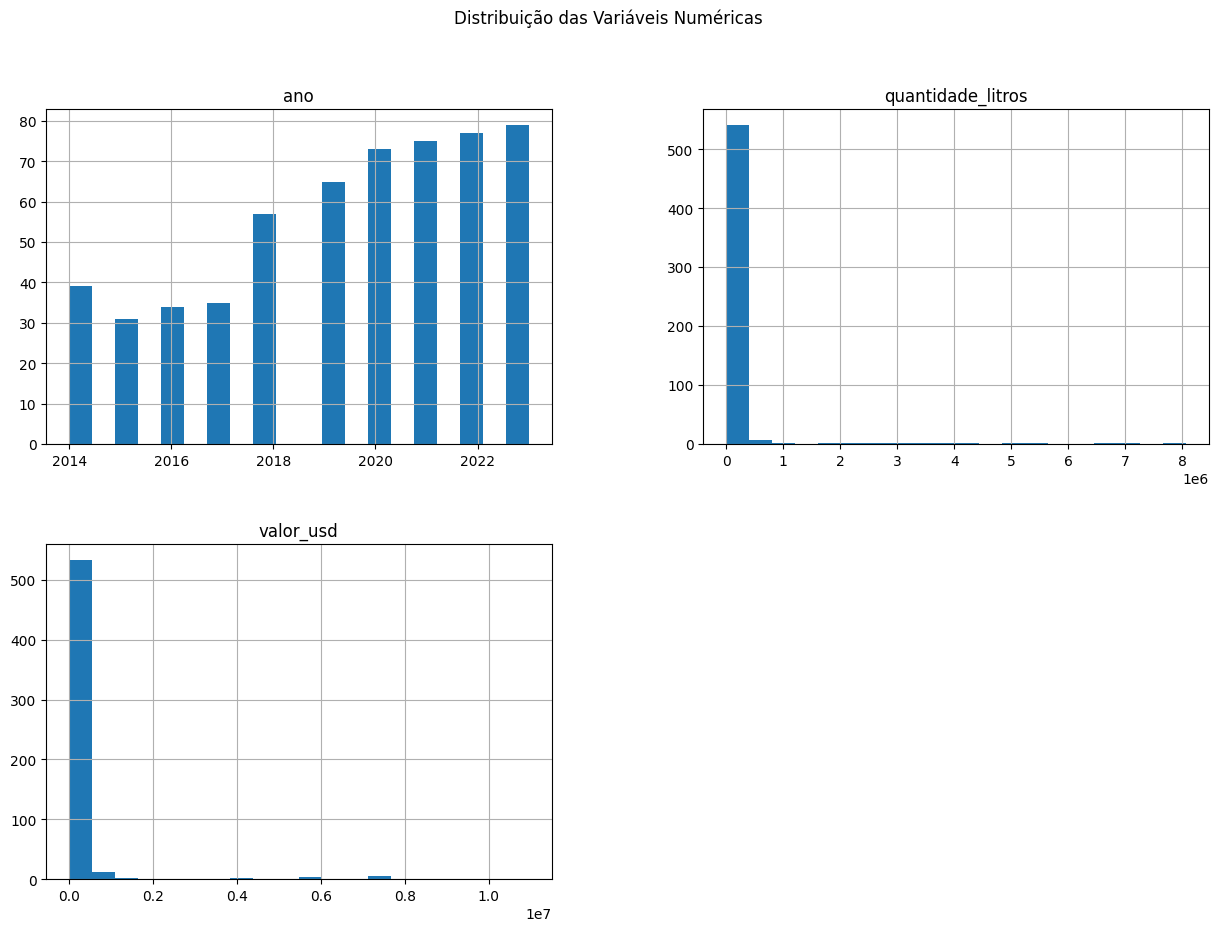

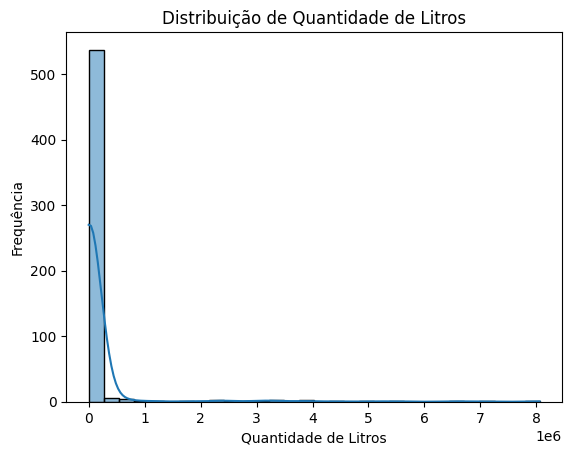

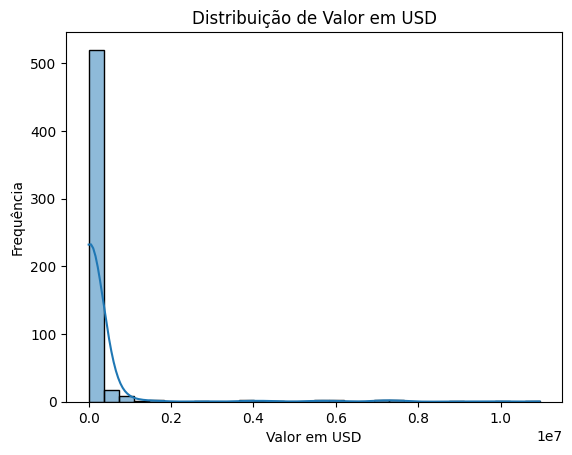

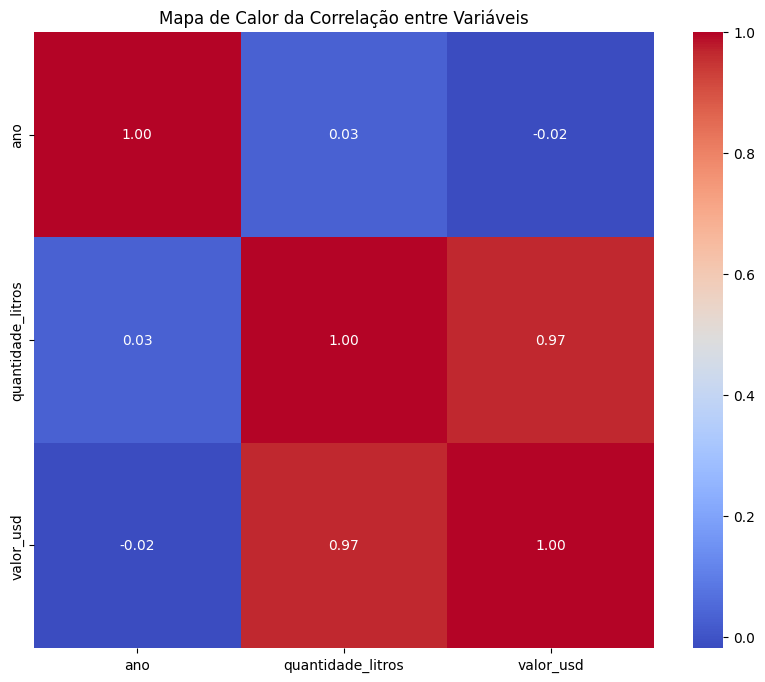

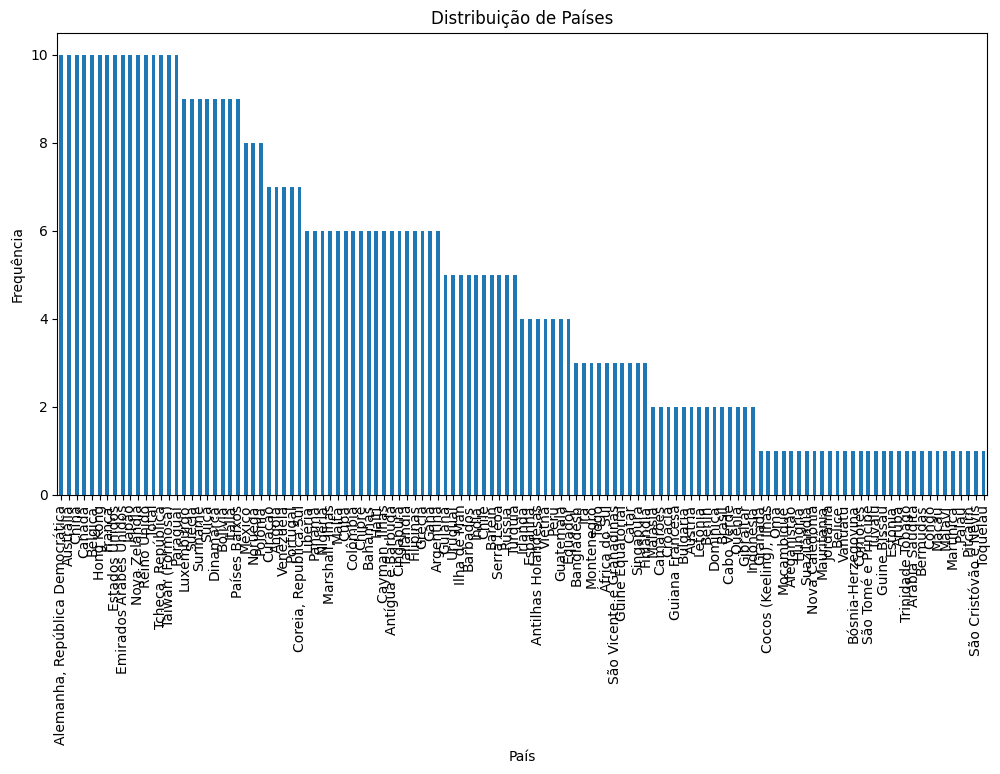

In [45]:
df_clean.head()
# Informações gerais sobre o DataFrame
df_clean.info()

# Estatísticas descritivas
df_clean.describe()

# Verificar a quantidade de valores nulos em cada coluna
df_clean.isnull().sum()


df_clean['ano'].value_counts()
df_clean['pais'].value_counts()


# Histograma para cada coluna numérica
df_clean.hist(bins=20, figsize=(15, 10))
plt.suptitle("Distribuição das Variáveis Numéricas")
plt.show()


# Distribuição da coluna 'quantidade_litros'
sns.histplot(df_clean['quantidade_litros'], kde=True, bins=30)
plt.title("Distribuição de Quantidade de Litros")
plt.xlabel("Quantidade de Litros")
plt.ylabel("Frequência")
plt.show()


# Distribuição da coluna 'valor_usd'
sns.histplot(df_clean['valor_usd'], kde=True, bins=30)
plt.title("Distribuição de Valor em USD")
plt.xlabel("Valor em USD")
plt.ylabel("Frequência")
plt.show()


# Matriz de correlação
df_numeric = df_clean.select_dtypes(include=['number'])
# Calcular a matriz de correlação
correlation_matrix = df_numeric.corr()

# Mapa de calor para visualizar a correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Mapa de Calor da Correlação entre Variáveis")
plt.show()

# Contagem de valores únicos na coluna 'pais'
df_clean['pais'].value_counts().plot(kind='bar', figsize=(12, 6))
plt.title("Distribuição de Países")
plt.xlabel("País")
plt.ylabel("Frequência")
plt.show()



Correlação entre quantidade_litros e valor_usd: 0.97


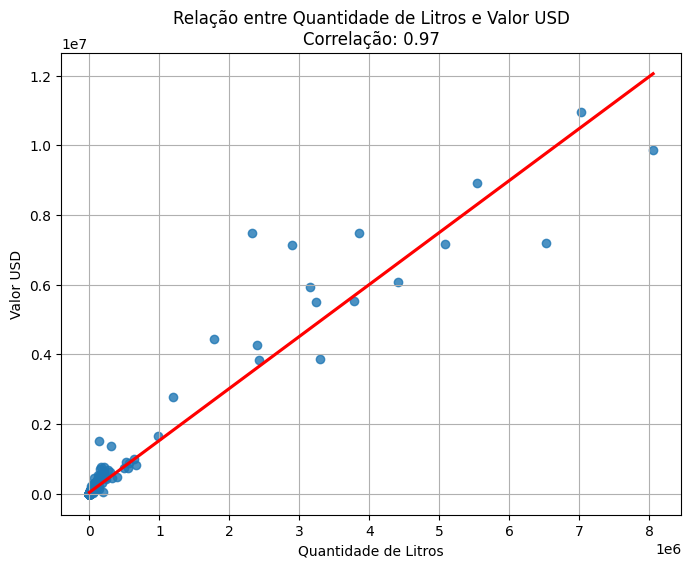

In [46]:
# Calcular a correlação
correlacao = df_clean[['quantidade_litros', 'valor_usd']].corr().iloc[0, 1]
print(f"Correlação entre quantidade_litros e valor_usd: {correlacao:.2f}")

# Scatter plot com linha de tendência
plt.figure(figsize=(8, 6))
sns.regplot(data=df_clean, x='quantidade_litros', y='valor_usd', ci=None, line_kws={"color": "red"})
plt.title(f"Relação entre Quantidade de Litros e Valor USD\nCorrelação: {correlacao:.2f}")
plt.xlabel("Quantidade de Litros")
plt.ylabel("Valor USD")
plt.grid()
plt.show()

In [47]:
df_clean.head()

,ano,pais,quantidade_litros,valor_usd
3,2022,"Alemanha, República Democrática",7630.0,45367.0
4,2022,Angola,4068.0,4761.0
6,2022,Antígua e Barbuda,419.0,1866.0
9,2022,Argentina,480.0,3232.0
11,2022,Austrália,1424.0,12299.0


In [48]:
# Definir as variáveis de entrada (X) e as variáveis de saída (y)
X = df_clean.drop(columns=['quantidade_litros','valor_usd'])  # Remover as colunas de saída
y = df_clean[['quantidade_litros', 'valor_usd']]  # Colunas de saída



In [49]:
X.head()

,ano,pais
3,2022,"Alemanha, República Democrática"
4,2022,Angola
6,2022,Antígua e Barbuda
9,2022,Argentina
11,2022,Austrália


In [50]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


# Exibir as dimensões dos conjuntos de treino e teste
print(f"Dimensões do conjunto de treino X: {X_train.shape}")
print(f"Dimensões do conjunto de teste X: {X_test.shape}")
print(f"Dimensões do conjunto de treino y: {y_train.shape}")
print(f"Dimensões do conjunto de teste y: {y_test.shape}")


Dimensões do conjunto de treino X: (452, 2)
Dimensões do conjunto de teste X: (113, 2)
Dimensões do conjunto de treino y: (452, 2)
Dimensões do conjunto de teste y: (113, 2)


## MODEL TRAINING

#### TRAINING (RANDOM FOREST REGRESSOR)

In [51]:

# Tratamento de dados faltantes e codificação de variáveis categóricas
numeric_features = ['ano']
categorical_features = ['pais']


# Pipeline para variáveis categóricas
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificar variáveis categóricas
])


# Combinar os transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ]
)



In [52]:
# Criar o modelo de Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)


# Pipeline completo
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf)
])

model.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['pais'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

#### EVALUATE MODEL

In [53]:
predictions = model.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"Mean Squared Error para : {mse}")
print(f"MAPE: {mape:.2f}%")
print(f"R2 Score para : {r2}")


Mean Squared Error para : 296024233441.3916
MAPE: 22.17%
R2 Score para : 0.7371013277140446


### PREDICT

In [65]:

novo_pais = 'Venezuela'

# Fazer previsões 
new_data = pd.DataFrame({
    'pais': [novo_pais]
})

# Fazer a previsão
predicao = model.predict(new_data)

# Garantir que valores negativos sejam exibidos como zero
quantidade_prevista = predicao[0][0]  # Quantidade de Litros
valor_previsto = predicao[0][1]  # Valor em USD

# Garantir que valores negativos sejam exibidos como zero
quantidade_prevista = max(quantidade_prevista, 0)
valor_previsto = max(valor_previsto, 0)

# Exibir os resultados
print(f"Previsão de exportacao para o país {novo_pais}:")
print(f"Quantidade Prevista: {quantidade_prevista:,.2f}")
print(f"Valor em USD Previsto: {valor_previsto:,.2f}")


Previsão de exportacao para o país Venezuela:
Quantidade Prevista: 30,282.46
Valor em USD Previsto: 46,213.23


### SAVE MODEL

In [63]:

# Obter o diretório atual do notebook
notebook_dir = os.getcwd()
parent_dir_two_levels_up = os.path.abspath(os.path.join(notebook_dir, os.pardir, os.pardir))
save_dir = os.path.join(parent_dir_two_levels_up, 'ml-model', 'production')
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, 'modelo_exportacao.pkl')
# Salvar o modelo treinado e o 
joblib.dump(model, model_path)
print(f"Modelo salvo em: {model_path}")

Modelo salvo em: /home/alberone/projects/fiap/ml-engineering/ml-tech-fiap-vitivinicultura-api/ml-model/production/modelo_exportacao.pkl


In [ ]:
pais_count = df_clean['pais'].value_counts()
pais_com_poucas_ocorrencias = pais_count[pais_count == 1].index

# Substituir esses países por "Outros"
df_clean['pais'] = df_clean['pais'].replace(pais_com_poucas_ocorrencias, 'Outros')

df_clean['pais'].value_counts()